In [1]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

### Assumptions

In [2]:
rho_w = 1000 # density of water [kg/m^3]

rho_cc = 2850 # density of continental crust [kg/m^3]
rho_cm = 3338 # density of continental lithospheric mantle [kg/m^3]
cc = 35000 # thickness of continental crust layer 
cm = 200000 # thickness of continental  mantle

rho_oc = 2900 # density of oceanic crust
rho_om = 3300 # density of depleted oceanic lithospheric mantle
oc = 7000 # thickness of oceanic crust layer 
om = 50000 # thickness of depleted oceanic lithospheric mantle

rho_m = 3300 # density of asthenospheric mantle
compensation_depth = cc + cm # compensation depth

g = 9.81

initial_depth = 0
depth_increment = 1000
final_depth = compensation_depth+depth_increment
z = np.array(range(initial_depth,final_depth,depth_increment))

### Isostatic balance equation
Isostatic balance equation (assume sea level = 0):

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_w w_A + \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

- $\rho_i$ is the density of water, oceanic crust, (depleted) oceanic mantle, (asthenospheric) mantle, continental crust, etc.
- $d_i$ is the thickness of the oceanic crust, continental crust, etc.
- $w_B$ is the thickness of the water layer above the oceanic lithosphere
- $w_A$ is the thickness of the water layer above the continental lithosphere.


where the compensation depth is taken as the base of the continental lithospheric mantle, which determines the depth of the asthenospheric mantle ($d_m$).

Assuming $w_A = 0$:

$$\rho_w w_B + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

Since we have two unknowns ($d_m$ and $w_B$), we use the equation:

$$d_{cc}+d_{cm} = w_B + d_{oc} + d_{om} + d_m$$

solving for $w_B$:
$$w_B = d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}$$

substituting into the isostatic balance equation:

$$\rho_w(d_{cc} + d_{cm} - d_{om} - d_m - d_{oc}) + \rho_{oc} d_{oc} + \rho_{om} d_{om} + \rho_m d_m = \rho_{cc} d_{cc} + \rho_{cm} d_{cm}$$

solving for $d_m$:
$$d_m = \frac{d_{cc}(\rho_{cc} - \rho_w) + d_{cm}(\rho_{cm} - \rho_w) + d_{om}(\rho_w - \rho_{om}) + d_{oc}(\rho_w - \rho_{oc})}{\rho_m -\rho_w}$$

In [3]:
# assuming continental crustal thickness of 35 km
m = (cc*(rho_cc-rho_w)+cm*(rho_cm-rho_w)+om*(rho_w-rho_om)+oc*(rho_w-rho_oc))\
/(rho_m-rho_w)
print("Thickness of the asthenospheric mantle layer under the oceanic lithosphere: %.0f km"% (m/1000))

Thickness of the asthenospheric mantle layer under the oceanic lithosphere: 176 km


now solving for $w_B$:

In [4]:
w_B = cc + cm - om - m - oc
print("Depth of the water layer above the oceanic lithosphere: %.0f km"% (w_B/1000))

Depth of the water layer above the oceanic lithosphere: 2 km


checking that this is indeed equal to the continental lithospheric layer:

In [5]:
print("Oceanic lithosphere: %i km"%((w_B+oc+om+m)/1000))
print("Continental lithosphere: %i km"%((cm+cc)/1000))

Oceanic lithosphere: 235 km
Continental lithosphere: 235 km


### Calculating the lithostatic pressure
$$P = \int_{a}^{b} \rho(z) g dz$$

#### Continental lithosphere

In [6]:
def calc_pressure_continent(z, w, cc):
    """
    Calculates the lithostatic pressure of the  continental lithosphere
    given the depth (z), water layer above (w), and thickness
    of the continental crust (cc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            # integrate the density over the water layer
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w + cc:
            # integrate the density over the crustal layer,
            # plus the total pressure from the water layer
            y, err = integrate.quad(lambda z: rho_cc*g,w,val)
            y+= rho_w*g*w
        elif w + cc <= abs(val) <= w + cc + cm:
            # integrate the density over the continental lithospheric mantle layer,
            # plus the total pressure from the water + crustal layer
            y, err = integrate.quad(lambda z: rho_cm*g,w+cc,val)
            y+= rho_w*g*w + rho_cc*g*cc
        else:
            # integrate the density over the mantle layer,
            # plus the total pressure from the water + crustal + cm layer
            y, err = integrate.quad(lambda z: rho_m*g,w+cc+cm,val)
            y+= rho_w*g*w + rho_cc*g*cc + rho_cm*g*cm
        P[i] = y/1e6
    return P

#### Oceanic lithosphere

In [7]:
def calc_pressure_ocean(z, w, oc):
    """
    Calculates the lithostatic pressure of the  oceanic lithosphere
    given the depth (z), water layer above (w), and thickness
    of the oceanic crust (oc)
    """
    P = np.array([0]*len(z))
    for i, val in enumerate(z):
        if abs(val) <= w:
            y, err = integrate.quad(lambda z: rho_w*g,0,val)
        elif w < abs(val) <= w+oc:
            y, err = integrate.quad(lambda z: rho_oc*g,w,val)
            y+= rho_w*g*w
        elif w+oc < abs(val) <= w+oc+om:
            y, err = integrate.quad(lambda z: rho_om*g,w+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc
        else:
            y, err = integrate.quad(lambda z: rho_m*g,w+om+oc,val)
            y+= rho_w*g*w + rho_oc*g*oc + rho_om*g*om
        P[i] = y/1e6
    return P

<Figure size 432x288 with 0 Axes>

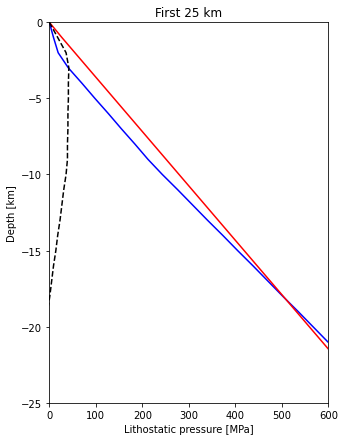

Maximum pressure difference: 42 MPa
Blue: oceanic lithosphere
Red: continental lithosphere


In [8]:
# assuming that continents are at sea level
w_A = 0
P_A = calc_pressure_continent(z, w_A, cc)
P_B = calc_pressure_ocean(z, w_B, oc)

plt.figure(1)
plt.figure(figsize=(5,7))
plt.plot(P_B,[-i/1000 for i in z],'b-')
plt.plot(P_A,[-i/1000 for i in z],'r-')
plt.plot(P_A-P_B,[-i/1000 for i in z],'k--')
plt.ylim((-25,0))
plt.xlim((0,600))
plt.title('First 25 km')
plt.xlabel('Lithostatic pressure [MPa]')
plt.ylabel('Depth [km]')
plt.show()
print("Maximum pressure difference: %i MPa"%max(P_A-P_B))
print("Blue: oceanic lithosphere\nRed: continental lithosphere")

<Figure size 432x288 with 0 Axes>

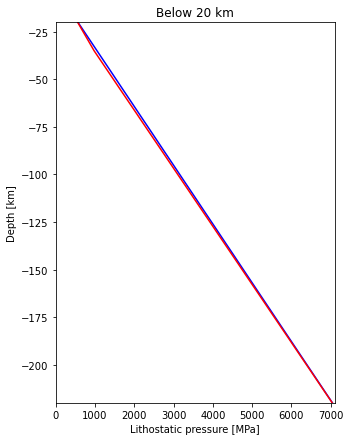

Maximum pressure difference: 75 MPa


In [9]:
plt.figure(2)
plt.figure(figsize=(5,7))
plt.plot(P_B,[-i/1000 for i in z],'b-')
plt.plot(P_A,[-i/1000 for i in z],'r-')
plt.ylim((-220,-20))
plt.xlim((0,7100))
plt.title('Below 20 km')
plt.xlabel('Lithostatic pressure [MPa]')
plt.ylabel('Depth [km]')
plt.show()
print("Maximum pressure difference: %i MPa"%max(P_B-P_A))

#### Varying the thickness of the continental crust

Trying $d_{cc}$ = 30, 40, 50 km

<Figure size 432x288 with 0 Axes>

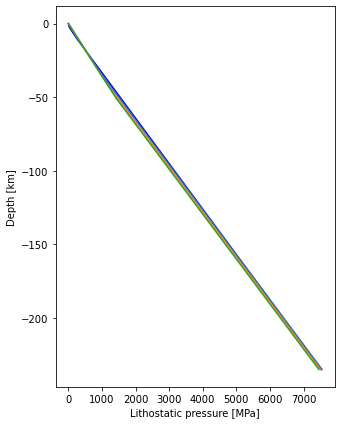

In [10]:
cc_range = list(range(30000,60000,10000))
plt.figure(3)
plt.figure(figsize=(5,7))
plt.plot(P_B,[-i/1000 for i in z],'b-')
for i in cc_range:
        P = calc_pressure_continent(z, w_A, i)
        plt.plot(P,[-j/1000 for j in z])
plt.xlabel('Lithostatic pressure [MPa]')
plt.ylabel('Depth [km]')
plt.show()

### Calculating the geotherm
Starting with the heat equation
$$0 = k\frac{d^2T}{dz^2}+\rho H$$

where $H$ is rate of internal heat production ($W/m^3$). Using the radiogenic heat production of the average continental crust as $H = 1\times10^{-6}$ $W/m^3$

Integrate to get:
$$C = k\frac{dT}{dz}+\rho Hz$$

Integrate again:
$$D+Cz = kT + \frac{1}{2}\rho Hz^2$$

$$T = \frac{Cz}{k}-\frac{1}{2k}\rho Hz^2 + D$$

From the boundary condition that $T(z=0) = 0$, we have $D = 0$. The temperature gradient within the continental crust is:

$$T_1 = \frac{C_1}{k_1}z-\frac{1}{2k_1}\rho Hz^2$$

where $C_1$ is the surface heat flow (from boundary condition $z = 0$)

The temperature at the base of the continental lithosphere is:
$$T_m = T_p + 240\left(\frac{\partial T}{\partial z}\right)$$

where the temperature potential of the mantle $T_p$ is $\sim 1350^{\circ}$C (now) and $1600^{\circ}$C (Archean)

We assume that the adiabatic gradient $\left(\frac{\partial T}{\partial z}\right) \sim 0.5$ K/km

Thus, $T_m \sim 1470^{\circ}$C (now) and $\sim 1720^{\circ}$C (Archean)

In [11]:
T_p = 1350
T_p_archean = 1600
dT_dz = 0.5
T_m = T_p + (cc+cm)/1000*dT_dz
T_m_archean = T_p_archean + (cc+cm)/1000*dT_dz
print("Assuming continental crustal thickness of %i [km]"%(cc/1000))
print("Mantle temperature: %i [C]"%T_m)
print("Archean mantle temperature: %i [C]"%T_m_archean)

Assuming continental crustal thickness of 35 [km]
Mantle temperature: 1467 [C]
Archean mantle temperature: 1717 [C]


The temperature gradient below the continental crust is:
$$T_2 = \frac{C_2}{k_2}z_2+D_2$$

We have three unknowns ($C_1$, $C_2$, $D_2$) and three boundary conditions.

At z = 40 km, we require that:
$$T_1 = T_2$$

$$\frac{dT_1}{dz} = \frac{dT_2}{dz}$$

at z = 240 km, we have:
$$T_2 = T_m$$

1) Using $\frac{dT_1}{dz} = \frac{dT_2}{dz}$:

$$\frac{C_1}{k_1}-\frac{\rho H}{k_1}z\Bigg\vert_{z = z_1} = \frac{C_2}{k_2}\Bigg\vert_{z=z_1}$$

$$\frac{1}{k_1}(C_1-\rho Hz_1) = \frac{1}{k_2}C_2$$

2) Using $T_1 = T_2$:
$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho Hz_1^2 = \frac{C_2}{k_2}z_1 + D_2$$

3) Using $T_2 = T_m$:
$$\frac{C_2}{k_2}z_2 + D_2 = T_m$$

where $z_1 = d_{cc}$ and $z_2 = d_{cc}+d_{cm}$

Combining (2) and (3):
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

$$\frac{C_1}{k_1}z_1 - \frac{1}{2k_1}\rho Hz_1^2 = \frac{C_2}{k_2}z_1 + T_m - \frac{C_2}{k_2}z_2$$

Writing $C_1$ in terms of $C_2$:
$$C_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho Hz_1$$

Solving for $C_2$ in (1):
$$\frac{1}{k_1}\left(\frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho Hz_1-\rho Hz_1\right) = \frac{1}{k_2}C_2$$

$$- C_2\frac{z_2}{z_1}  =\frac{1}{2}\frac{k_2}{k_1}\rho Hz_1- k_2\frac{T_m}{z_1}$$

$$C_2\left(- \frac{z_2}{z_1}\right)  =\frac{1}{2}\frac{k_2}{k_1}\rho Hz_1- k_2\frac{T_m}{z_1}$$

$$C_2 =\frac{k_2T_m-\frac{1}{2}\frac{k_2}{k_1}\rho Hz_1^2 }{z_2}$$

In [12]:
k_1 = 3.0 # Thermal conductivity of the crustal layer [W/mK] (assume constant)
k_2 = 3.0 # Thermal conductivity of the upper mantle
H = 1*10**(-6) # radiogenic heat production of the average continental crust [W/m^3]
C_2 = (k_2*T_m-(1/2)*(k_2/k_1)*rho_cc*H*cc**2)/(cc+cm)
print("C_2 = %.2f"%C_2)

C_2 = -7.41


calculating $C_1$ from $C_2$:
$$C_1 = \frac{C_2k_1}{k_2} - \frac{C_2k_1}{k_2}\frac{z_2}{z_1} + \frac{T_mk_1}{z_1} + \frac{1}{2}\rho Hz_1$$

In [13]:
C_1 = (C_2*k_1)/k_2 - (C_2*k_1*(cc+cm))/cc + (T_m*k_1)/cc + (1/2)*rho_cc*H*cc
print("C_1 = %.2f"%C_1)

C_1 = 191.84


calculating $D$ from $C_2$:
$$D_2 = T_m - \frac{C_2}{k_2}z_2$$

In [14]:
D_2 = T_m-(C_2*(cc+cm))/k_2
print("D_2 = %.2f"%D_2)

D_2 = 581875.00


* These numbers look a bit weird, check units?
* $\rho$ depends on depth $\rho(z)$?

In [15]:
def calc_geotherm(z):
    """
    Calculates the geothermal gradient up to depth (z),
    (for now) assuming that thermal conductivity is constant
    and that values for the crust and mantle are both k = 3.0
    """
    T = np.ones(len(z))
    T_0 = 273 # surface temperature [K]
    
    # index of end of crustal layer
    i = int(np.where(z==cc)[0])
    
    # temperature within the crust 
    for j, val in enumerate(z[:i]):
        T[j] = T_0 + (C_1*val)/k_1 - ((rho_cc*H*val**2)/(2*k_1))
    # temperature below the crust
    for m, val in enumerate(z[i:]):
        T[m+j+1] = T[j] + ((val-cc)/k_2)*C_2+D_2
    return T

<Figure size 432x288 with 0 Axes>

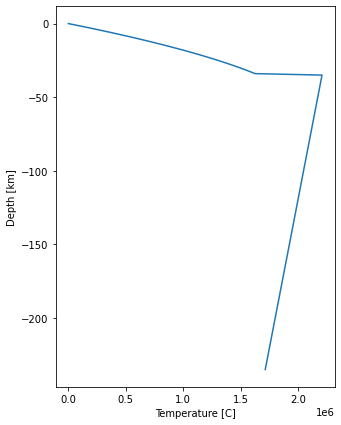

In [16]:
T = calc_geotherm(z)
plt.figure(4)
plt.figure(figsize=(5,7))
plt.plot(T-273,[-i/1000 for i in z])
plt.xlabel('Temperature [C]')
plt.ylabel('Depth [km]')
plt.show()

something's wrong 